In [329]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33443 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33443/status,
Dashboard: http://127.0.0.1:33443/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44989,Workers: 15
Dashboard: http://127.0.0.1:33443/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:36677,Total threads: 1
Dashboard: http://127.0.0.1:44403/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:36593,


In [330]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')
# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()
# Load control simulation 
preprocess = lambda ds: croco_sellonlatbox(ds[['temp','salt','u','w','v','zeta','h','Cs_r','hc','hbl']],  360-71.7, 360-71.22, -30.35, -29.15)
pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y*.nc'))
control_avg      = xr.open_mfdataset(pathsavg_control, parallel=True, preprocess=preprocess)
control_avg      = fix_crocotime(control_avg, YORIG='1949-12-30 23:59:50')
control_avg      = center_crocogrid(control_avg, control_avg.keys()).load()


/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [331]:
def croco_coordsfromlatlon(data, lon, lat):
    """
    This functions finds the nearest point for the given lat,lon 
    coordinates.

    Args:
        data (_type_): _description_
        lon (_type_): _description_
        lat (_type_): _description_

    Returns:
        _type_: _description_
    """
    eta = abs(data.lat_rho-lat).argmin(axis=0)[0].item()
    eta = data.isel(eta_rho=eta).eta_rho.item()
    
    xi  = abs(data.lon_rho-lon).argmin(axis=1)[0].item()
    xi  = data.isel(xi_rho=xi).xi_rho.item()
    return eta,xi

def croco_cross_section(data, start, end, npoints=100, method='linear'):
    """
    Interpolate a croco vertical cross section

    Args:
        data (_type_): _description_
        start (_type_): _description_
        end (_type_): _description_
        npoints (int, optional): _description_. Defaults to 100.
        method (str, optional): _description_. Defaults to 'bilinear'.

    Returns:
        _type_: _description_
    """
    # Grab given coordinates and create cross section points
    lat1,lon1 = start
    lat2,lon2 = end
    points = (np.linspace(start[0], end[0], npoints),
              np.linspace(start[1], end[1], npoints))
    
    # From coordinates get positions, eta and xi
    eta1,xi1  = croco_coordsfromlatlon(data, lon1, lat1)
    eta2,xi2  = croco_coordsfromlatlon(data, lon2, lat2)

    etas      = xr.DataArray(np.linspace(eta1, eta2, npoints), dims='distance')
    xis       = xr.DataArray(np.linspace(xi1, xi2, npoints), dims='distance')
    
    cross    = data.interp(eta_rho=etas, xi_rho=xis, method=method)
    distance = [haversine((start[0], start[1]), (lat,lon))
                for lat,lon in zip(points[0], points[1])]
    cross.coords['distance'] = ('distance', distance)

    return cross
    

def croco_selpoint(data, lon, lat, interp=False):
    """
    This functions finds the nearest point for the given lat,lon 
    coordinates.

    Args:
        data (_type_): _description_
        lon (_type_): _description_
        lat (_type_): _description_

    Returns:
        _type_: _description_
    """
    eta = abs(data.lat_rho-lat).argmin(axis=0)[0].item()
    xi  = abs(data.lon_rho-lon).argmin(axis=1)[0].item()
    if interp == False:
        return data.isel(eta_rho=eta, xi_rho=xi)
    else:
        x = data.isel(eta_rho=eta).isel(xi_rho=xi)
        eta,xi = x.eta_rho.item(), x.xi_rho.item()
        return data.interp(xi_rho=xi, eta_rho=eta)

In [414]:
start  = (-30.242, 360-71.627)
end    = (-29.255, 360-71.472)
cross  = croco_cross_section(control_avg, start, end, npoints=150)

# perform vertical interpolation sigma -> z
zcross = rhopoints_depths(cross.h.expand_dims(dim={'s_rho':control_avg.s_rho}), cross.zeta, cross.s_rho, cross.Cs_r, cross.hc).load().rename('z')
target_depths = np.hstack([np.arange(0,100,0.5), np.arange(100, 500, 2.5), np.arange(500, 1050, 5)])
husk = xgcm.Grid(cross, coords={'z':{'center':'s_rho'}}, periodic=False)
temp = husk.transform(cross.temp,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
salt = husk.transform(cross.salt,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
u = husk.transform(cross.u,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
v = husk.transform(cross.v,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
w = husk.transform(cross.w,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)

X,Z = np.meshgrid(cross.distance, target_depths)
for i in range(Z.shape[1]):
    depth = cross.h.isel(time=0).isel(distance=i).item()
    Z[:,i] = Z[:,i] > depth
Z = ~Z.astype(bool).T


cross = xr.merge([u.where(Z),v.where(Z),w.where(Z),temp.where(Z),salt.where(Z),
                  cross.h.isel(time=0), cross.hbl, cross.zeta])



(-1050.0, 0.0)

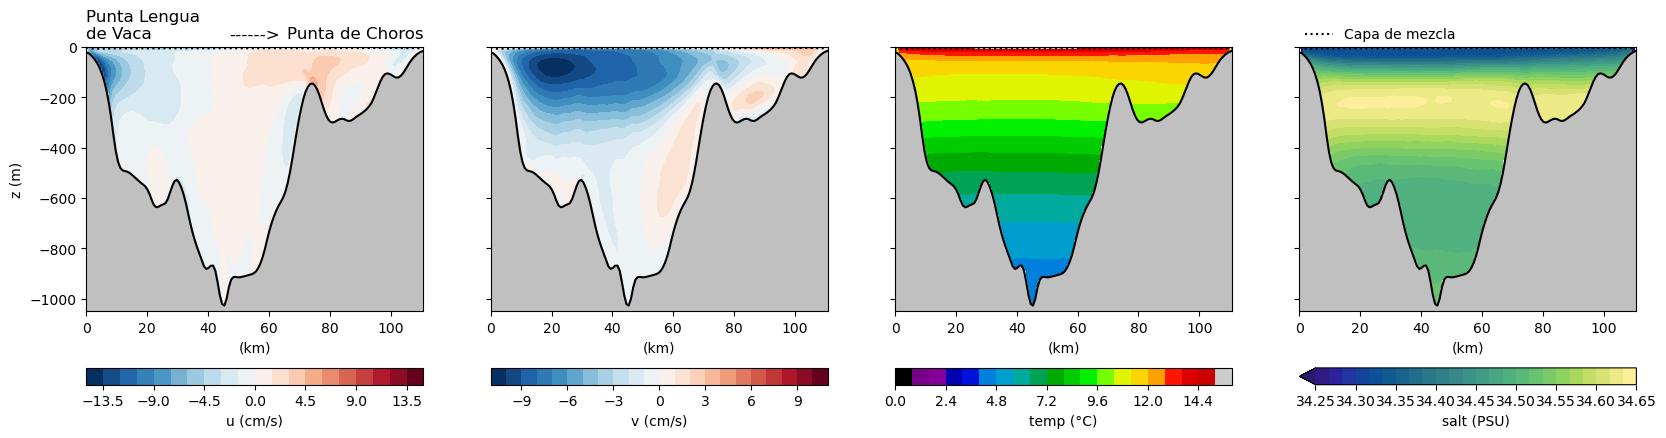

In [338]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(20,5), facecolor='w', dpi=100)


(cross.sel(time='2001').u.mean('time')*100).plot.contourf(levels=25,x='distance', y='z', ax=ax[0], zorder=0, cbar_kwargs={'label':'u (cm/s)','orientation':'horizontal'})
(cross.sel(time='2001').v.mean('time')*100).plot.contourf(levels=25,x='distance', y='z', ax=ax[1], zorder=0, cbar_kwargs={'label':'v (cm/s)','orientation':'horizontal'})
(cross.sel(time='2001').temp.mean('time')).plot.contourf(levels=25,x='distance', y='z', ax=ax[2], zorder=0, cbar_kwargs={'label':'temp (°C)','orientation':'horizontal'}, cmap='nipy_spectral')
(cross.sel(time='2001').salt.where(cross.salt!=0).mean('time')).plot.contourf(levels=25,x='distance', y='z', ax=ax[3], zorder=0, cbar_kwargs={'label':'salt (PSU)','orientation':'horizontal'}, cmap=cmocean.cm.haline,
                                                             vmin=34.25, vmax=34.65)

for i,axis in enumerate(ax.ravel()):
    (-cross.hbl.mean('time')).plot(ax=axis, color='k', ls=':', x='distance', label='Capa de mezcla')
    axis.fill_between(cross['distance'], -cross.h,
                      -np.ones(len(cross.h))*1100,
                      zorder=1, color='silver')
    axis.plot(cross['distance'], -cross.h, color='k')
    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('(km)')
ax[0].set_ylabel('z (m)')
ax[0].set_title('Punta Lengua\nde Vaca', loc='left')
ax[0].set_title('------>', loc='center')
ax[0].set_title('Punta de Choros', loc='right')
ax[-1].legend(loc=(0,1), frameon=False)
ax[0].set_ylim(-1050,0)



In [427]:
baseline = cross.resample({'time':'m'}).mean()
baseline['time'] = baseline['time']-pd.Timedelta(days=16)
baseline = baseline.fillna(0).resample({'time':'d'}).interpolate(kind='cubic').reindex({'time':cross.time.values}, method='nearest')


In [597]:
from sklearn.decomposition import PCA
from scipy.cluster.vq import whiten
cross_sanomaly = (cross-baseline).fillna(0).sel(z=slice(0,-400)).sel(distance=slice(0,70))
eofmatrix      = cross_sanomaly.u.data.reshape(len(cross_sanomaly.time), len(cross_sanomaly.z)*len(cross_sanomaly.distance)),cross_sanomaly.v.data.reshape(len(cross_sanomaly.time), len(cross_sanomaly.z)*len(cross_sanomaly.distance))
eofmatrix      = np.hstack(eofmatrix)
# eofmatrix = whiten(eofmatrix)
pca   = PCA(n_components=5, whiten=False).fit(eofmatrix)
pc  = pca.transform(eofmatrix)
r2  = pca.explained_variance_ratio_

pc  = xr.DataArray(pc, coords={'time':cross_sanomaly.time.values,'comp':range(5)})
eof = xr.corr(cross_sanomaly.u,pc, 'time')


/tmp/ipykernel_17850/854563135.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EOF{}'.format(int(x)) for x in ax.get_xticks()])


Text(0.5, 1.0, 'Fraccion de varianza explicada')

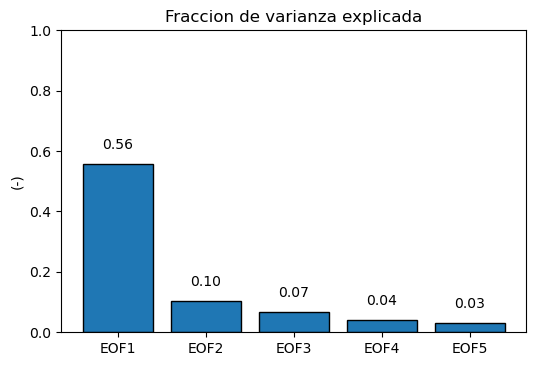

In [592]:
fig = plt.figure(facecolor='w', dpi=100)
ax  = fig.add_subplot(111)
ax.bar(range(1,5+1), r2, edgecolor='k')

for j in range(5):
    ax.text(j+1, r2[j]+0.05, '{:.2f}'.format(r2[j]), ha='center')
ax.set_ylim(0,1)
ax.set_xticklabels(['EOF{}'.format(int(x)) for x in ax.get_xticks()])
ax.set_ylabel('(-)')
ax.set_title('Fraccion de varianza explicada')

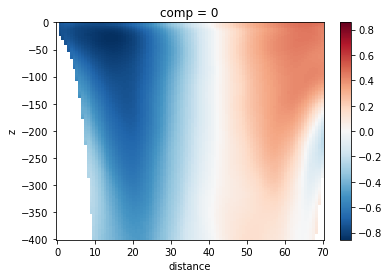

In [598]:
eof.isel(comp=0).plot(x='distance')

In [490]:
preprocess = lambda ds: ds[['u','v','zeta','salt']].isel(s_rho=-1)
pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y*.nc'))
control_surf      = xr.open_mfdataset(pathsavg_control, parallel=True, preprocess=preprocess)
control_surf      = fix_crocotime(control_surf, YORIG='1949-12-30 23:59:50')
control_surf      = center_crocogrid(control_surf, control_surf.keys()).load()


In [616]:
pc.isel(comp=1).to_series().sort_values().head(20)

time
2004-06-18 12:00:00   -30.583260
2004-06-17 12:00:00   -27.454505
2004-06-19 12:00:00   -26.296707
2004-11-06 12:00:00   -25.318003
2004-11-05 12:00:00   -25.008456
2004-06-16 12:00:00   -23.323391
2002-09-11 12:00:00   -23.147979
2004-11-07 12:00:00   -22.465649
2002-09-12 12:00:00   -22.413259
2004-11-04 12:00:00   -22.233024
2002-01-14 12:00:00   -20.679254
2004-11-08 12:00:00   -20.034502
2001-02-24 12:00:00   -19.965612
2002-04-28 12:00:00   -19.553410
2002-01-13 12:00:00   -19.507919
2001-02-23 12:00:00   -19.076967
2004-10-22 12:00:00   -18.772465
2001-02-25 12:00:00   -18.298463
2001-11-17 12:00:00   -17.974296
2001-02-22 12:00:00   -17.739947
dtype: float64

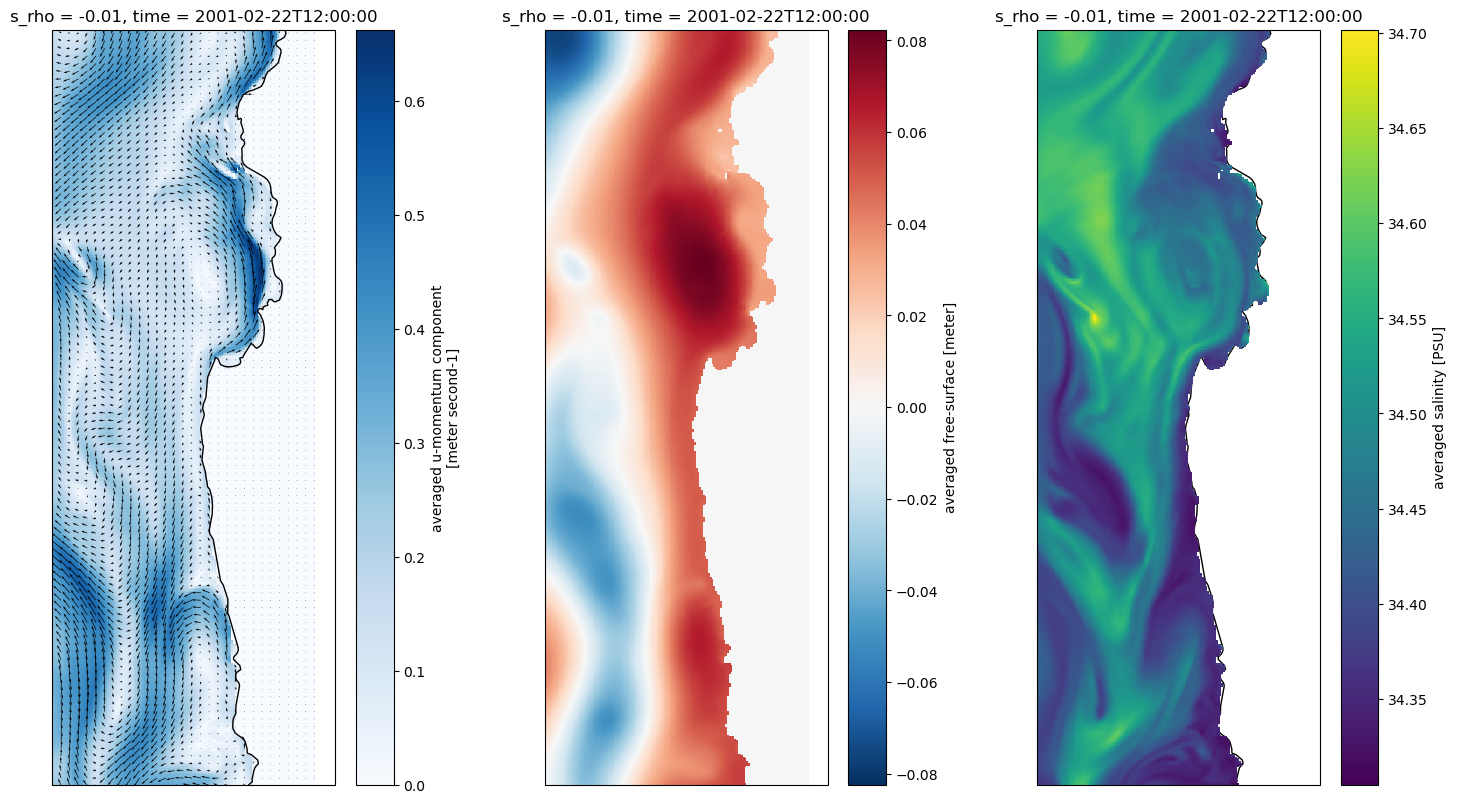

In [617]:
x = control_surf.sel(time='2001-02-22').squeeze()
fig, ax = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()}, facecolor='w', dpi=100, figsize=(18,10))
for axis in ax:
    axis.set_extent([-72.5,-71,-32.5,-28.5])
    axis.coastlines('10m')
    
n=5
ax[0].quiver(x.lon_rho.values[::n,::n], x.lat_rho.values[::n,::n], x.u.values[::n,::n], x.v.values[::n,::n], zorder=1, scale=10)
cs = np.hypot(x.u,x.v)
cs.plot(ax=ax[0], x='lon_rho', y='lat_rho', cmap='Blues', zorder=0)
x.zeta.plot(ax=ax[1], x='lon_rho', y='lat_rho')

x.salt.where(x.salt!=0).plot(ax=ax[2], x='lon_rho', y='lat_rho')